# Compare Classification Techniques

Credits: Heavily based on the [Customer Churn](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html) blog entry.

Apply the same steps as in the Customer Churn notebook, on the [HR Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data set.  
Purpose: get familiar with (binary) classification techniques, including:
  * Logistic regression
  * Gradient Boosting Classifier
  * Support Vector Machines
  * Random Forest
  * K-nearest-neighbors

## Intro

```
ML
├── Supervised Learning <= dataset = features + labels.
│   ├── Regression <= label is continuous.
│   │       e.g. estimate age.
│   └── Classification <= label is discrete.
│           e.g. determine if an object is a star, a galaxy or a quasar.
│
└── Unsupervised Learning <= no labels, find similarities
    ├── ...
```

## Dataset::Inspect

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
employees = pd.read_csv('d:\MyCode\Playground\eMeL\datas\HR_comma_sep.csv')
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Hm... the `sales` feature seems to represent the department, maybe the name stuck from the first entry. Whatever the reason, let's rename it for better reasoning further on.

In [3]:
employees = employees.rename(columns = {'sales': 'department'})

In [4]:
employees.shape

(14999, 10)

In [5]:
employees.mean()

satisfaction_level         0.612834
last_evaluation            0.716102
number_project             3.803054
average_montly_hours     201.050337
time_spend_company         3.498233
Work_accident              0.144610
left                       0.238083
promotion_last_5years      0.021268
dtype: float64

=> 23% of the employees left during the last 5 years...

### How are the features related to one another?

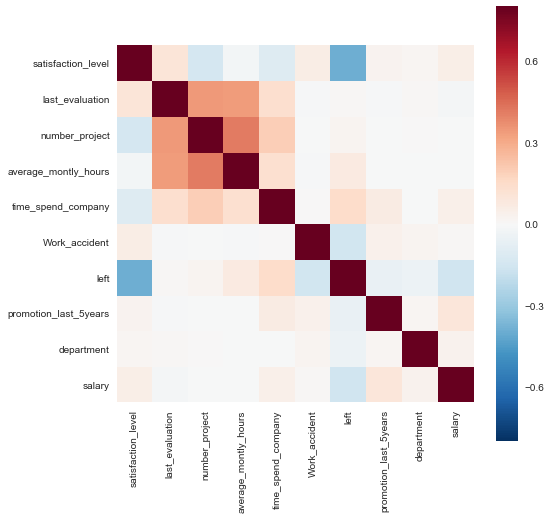

In [11]:
import seaborn as sns

correlation_matrix = employees.corr()
plt.subplots(figsize = (8, 8))

sns.heatmap(correlation_matrix, vmax = .8, square = True)
plt.show()

Notice that the string features are missing from the correlation matrix, i.e. the salary and the department.

## Dataset::Preprocess

### Convert string features to numbers

In [6]:
# First the salary... 
employees['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [7]:
employees['salary'] = pd.factorize(employees['salary'])[0]

In [8]:
# ... and then the department.
employees['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [9]:
employees['department'] = pd.factorize(employees['department'])[0]
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,0,0
1,0.80,0.86,5,262,6,0,1,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0


### Draw correlation again, this time including the salary and the department

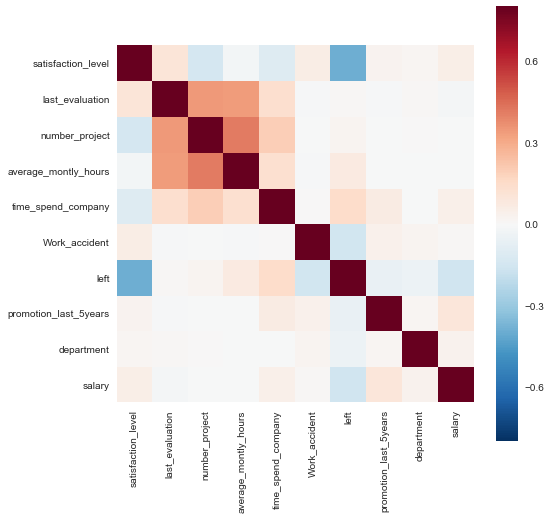

In [12]:
correlation_matrix = employees.corr()
plt.subplots(figsize = (8, 8))

sns.heatmap(correlation_matrix, vmax = .8, square = True)
plt.show()

The churn rate seems to be most related to the satisfactory level, to the time spent in the company and to the salary.  
On the other side, it seems to be almost not at all related to the last evaluation or the department.

### Isolate data of interest

In [13]:
# Target data
leave_result = employees['left']
y = np.where(leave_result == 1, 1, 0)
y

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
# Remove the "left" column. It is not a feature, it is the target.
# Then convert the df. to a matrix, 
X = employees.drop('left', axis = 1).as_matrix().astype(np.float)
X

array([[ 0.38,  0.53,  2.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.8 ,  0.86,  5.  , ...,  0.  ,  0.  ,  1.  ],
       [ 0.11,  0.88,  7.  , ...,  0.  ,  0.  ,  1.  ],
       ..., 
       [ 0.37,  0.53,  2.  , ...,  0.  ,  4.  ,  0.  ],
       [ 0.11,  0.96,  6.  , ...,  0.  ,  4.  ,  0.  ],
       [ 0.37,  0.52,  2.  , ...,  0.  ,  4.  ,  0.  ]])

### Standardize, [scale](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) data

Doing this dramatically decreases the run time of the SVM classifier and it also increases the accuracy of most of the classifiers.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels: ", np.unique(y))

Feature space holds 14999 observations and 9 features
Unique target labels:  [0 1]


## Classifiers::Run

### Helper methods

The data is split into test-train sets using [K-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29#/media/File:K-fold_cross_validation_EN.jpg). This should lead to a more accurate estimate of model prediction performance.

In [55]:
from sklearn.model_selection import KFold

# Results: {'pred': y_pred, 'time': seconds, true-positive-rate': tpr, 'false-positive-rate': fpr }

def run_clf(X, y, clf):
    start = time.time()
    
    y_pred = y.copy()
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    t = 0.0
    
    # Construct a kfolds object
    kf = KFold(n_splits = 3, shuffle = True)
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Run
        clf.fit(X_train, y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y[test_index], y_pred[test_index])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
    
    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
        
    end = time.time()
    t = end - start
    
    return { 'y_pred': y_pred, 
             'time': t, 
             'true-positive-rate': mean_tpr, 
             'false-positive-rate': mean_fpr }

In [17]:
# Add measurements
import time
def measure_cv(X, y, clf):
    start = time.time()
    result = run_cv(X, y, clf)
    end = time.time()
    print("[time: %.3f]" % (end - start))
    return result

### Run, Classifiers, run!


In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import average_precision_score

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors = 3),
    "Linear SVM": SVC(kernel = "linear", C = 0.025),
#    "RBF SVM": SVC(gamma = 2, C = 1), # takes quite a lot
#    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), warm_start = True), # takes ages
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 18),
    "Neural Net": MLPClassifier(alpha = 1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis() 
}

def runall():
    results = {}
    for clf_name, clf in classifiers.items():
        results[clf_name] = run_clf(X, y, clf)
        print("%s: %.3fs" % (clf_name, results[clf_name]['time']))
    return results
        
results = runall()

Nearest Neighbors: 1.479s
Linear SVM: 6.453s
Gradient Boosting Classifier: 1.607s
Decision Tree: 0.094s
Random Forest: 0.473s
Neural Net: 5.801s
AdaBoost: 1.075s
Naive Bayes: 0.016s
QDA: 0.031s



## Classifiers::Compare::Accuracy

In [58]:
def accuracy(y_true, y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

for clf_name, result in results.items():
    print("{0:30}: {1:.3f}".format(clf_name, accuracy(y, result['y_pred'])))

Nearest Neighbors             : 0.959
Linear SVM                    : 0.781
Gradient Boosting Classifier  : 0.976
Decision Tree                 : 0.977
Random Forest                 : 0.989
Neural Net                    : 0.954
AdaBoost                      : 0.959
Naive Bayes                   : 0.793
QDA                           : 0.909


Here's to the **Random Forest**!

### Classifiers::Compare::Confusion Matrix

Reasoning: the accuracy measure above treats false positives and false negatives equally.  
  * Predict that employee will leave + employee stays: mkay, no biggie.
  * Predict that employee will stay + employee leaves: ouch.

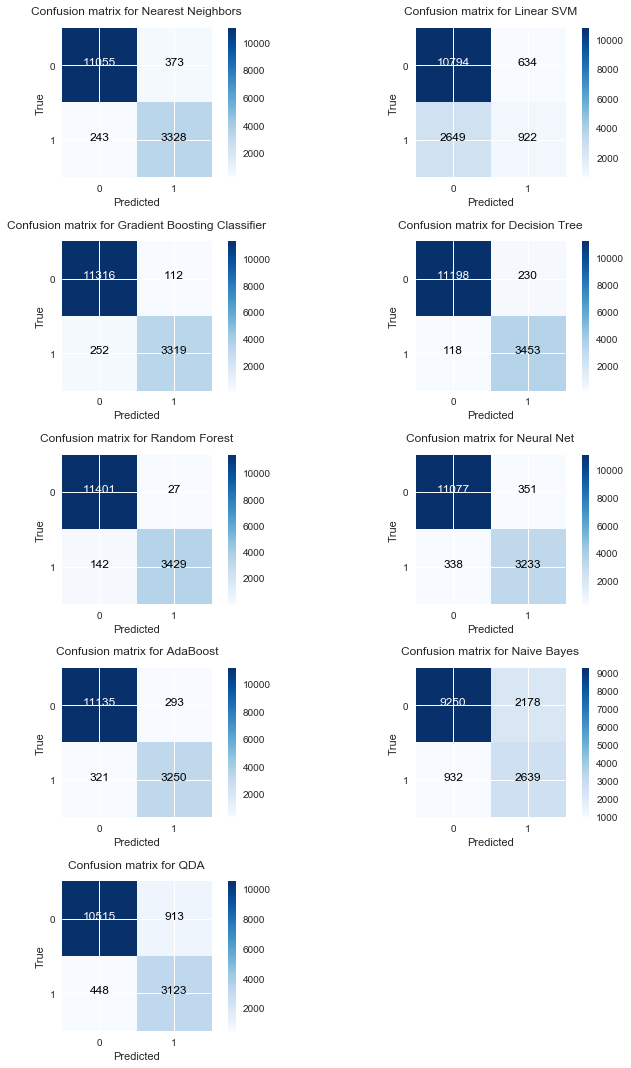

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def draw_confusion_matrices(cms, classes):
    fig = plt.figure(figsize = (10, 15))
    
    i = 1   # used to compute the matrix location
    for clf_name, cm in cms.items():
        thresh = cm.max() / 2   # used for the text color
        
        ax = fig.add_subplot(len(cms) / 2 + 1, 2, i,
                             title = 'Confusion matrix for %s' % clf_name, 
                             xlabel = 'Predicted',
                             ylabel = 'True')
        cax = ax.matshow(cm, cmap = plt.cm.Blues)
        fig.colorbar(cax)
        i += 1
        
        # Ticks
        ax.set_xticklabels([''] + classes)
        ax.set_yticklabels([''] + classes)
        ax.tick_params(labelbottom = True, labelleft = True, labeltop = False)
        
        # Text
        for x in range(len(cm)):
            for y in range(len(cm[0])):
                ax.text(y, x, cm[x, y], 
                        horizontalalignment = 'center', 
                        color = 'black' if cm[x, y] < thresh else 'white')
        
    plt.tight_layout()
    plt.show()

matrices = {}
for clf_name, result in results.items():
    matrices[clf_name] = confusion_matrix(y, result['y_pred'])

labels = np.unique(y).tolist()
draw_confusion_matrices(matrices, labels)

Q1: When an individual leaves, how often does the classifier predict that correctly? A.K.A. *recall* or *sensitivity* or *probability of detection* (that is, the true positive rate).  
A1: Best: Random Forests; So much worse: Logistic Regression.  

Q2: When a classifier predicts that an individual will leave, how oftern does that individual actually leave? A.K.A. *precision*.  
A2: Same.

### Interimary conclusion: accuracy, recall and precision all rank Random Forests above others.

I believe that, in theory, it should suffice for us to draw the line and go for the Random Forests.  
However, for the sake of learning, we will continue comparing the classifiers.

### Classifiers::Compare::ROC Plots & AUC

The Area Under Curve (AUC) of a Receiver Operating Characteristic (ROC) curve => a single value that represents the expected performance.

Method: plot True Positive Rate (recall / sensitivity / probability of detection) against False Positive Rate (fall-out / probability of false alarm).

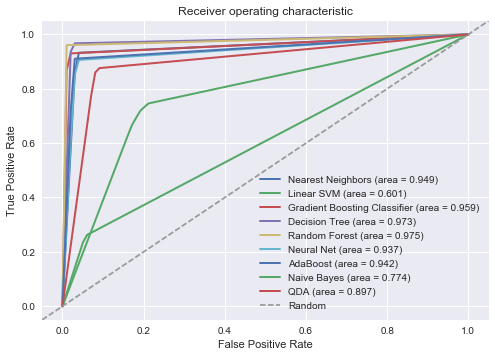

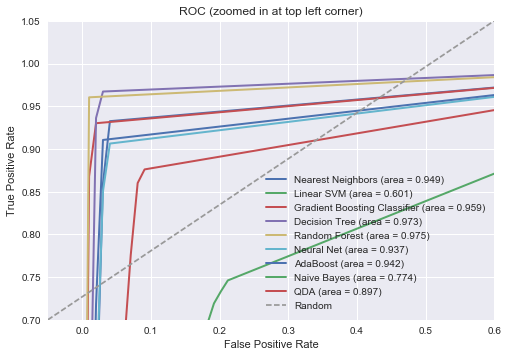

In [60]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_all(title, max_x, min_y):
    for clf_name, result in results.items():
        fpr = result['false-positive-rate']
        tpr = result['true-positive-rate']
        mean_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw = 2, label = '%s (area = %0.3f)' % (clf_name, mean_auc))
        
    plt.plot([-0.05, max_x], [min_y, 1.05], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim(-0.05, max_x)
    plt.ylim(min_y, 1.05)   
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
plt.figure(1)
plot_all('Receiver operating characteristic', 1.05, -0.05)

plt.figure(2)
plot_all('ROC (zoomed in at top left corner)', 0.6, 0.7)